### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense,Input
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import os

### Dataset 

source: https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature


In [2]:
train_df = pd.read_csv("measures_v2.csv")



In [6]:
train_df.isna().sum()

u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
profile_id        0
dtype: int64

There are no unknown values

### Standardization

In [3]:

X = train_df[train_df['profile_id'] != 17].drop(columns = ['pm','profile_id'])
y = train_df['pm'][train_df['profile_id'] != 17]

X_test = train_df[train_df['profile_id'] == 17].drop(columns = ['pm','profile_id'])
y_test = train_df['pm'][train_df['profile_id'] == 17]

scaler1 = StandardScaler()
scaler2 = StandardScaler()
X = scaler1.fit_transform(X)
y = scaler2.fit_transform(np.asarray(y).reshape(-1, 1))

X_test = scaler1.transform(X_test)
y_test = scaler2.transform(np.asarray(y_test).reshape(-1, 1))


pm-Permanent magnet temperature will be the target variable


In [45]:
train_df["profile_id"].unique()

array([17,  5, 12, 32, 21,  2,  4,  7, 19,  3,  9, 23, 27, 26, 11,  6, 10,
       13, 31, 18, 30, 29,  8, 24, 20, 15, 14, 16, 36, 74, 75, 41, 68, 50,
       53, 49, 81, 80, 59, 54, 57, 70, 51, 55, 45, 69, 61, 76, 56, 64, 72,
       73, 62, 65, 63, 43, 47, 66, 42, 48, 67, 44, 79, 52, 60, 46, 58, 78,
       71], dtype=int64)

### Training

In [12]:
model = keras.Sequential([
    Input(shape=(X.shape[1])),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='linear')
])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                384       
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5)]

In [61]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.6)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=1,
    batch_size=32,
    callbacks=callbacks,
    validation_data=(X_val, y_val)
    )

Epoch 1/100
16436/16436 [==============================] - 16s 968us/step - loss: 0.0475 - val_loss: 0.0463 - lr: 0.0010
Epoch 2/100
16436/16436 [==============================] - 16s 969us/step - loss: 0.0473 - val_loss: 0.0457 - lr: 0.0010
Epoch 3/100
16436/16436 [==============================] - 16s 949us/step - loss: 0.0471 - val_loss: 0.0500 - lr: 0.0010
Epoch 4/100
16436/16436 [==============================] - 16s 963us/step - loss: 0.0469 - val_loss: 0.0452 - lr: 0.0010
Epoch 5/100
16436/16436 [==============================] - 16s 971us/step - loss: 0.0468 - val_loss: 0.0454 - lr: 0.0010
Epoch 6/100
16436/16436 [==============================] - 16s 970us/step - loss: 0.0466 - val_loss: 0.0463 - lr: 0.0010
Epoch 7/100
16436/16436 [==============================] - 16s 964us/step - loss: 0.0466 - val_loss: 0.0464 - lr: 0.0010
Epoch 8/100
16436/16436 [==============================] - 16s 971us/step - loss: 0.0464 - val_loss: 0.0456 - lr: 0.0010
Epoch 9/100
16436/16436 [=======

KeyboardInterrupt: 

### Evaluation

In [64]:
evaluation=model.evaluate( X_test, y_test, verbose=1)

499/499 [==============================] - 0s 377us/step - loss: 0.0110


In [142]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 4])
  plt.xlabel('Epoch')
  plt.ylabel('Error [PM]')
  plt.legend()
  plt.grid(True)

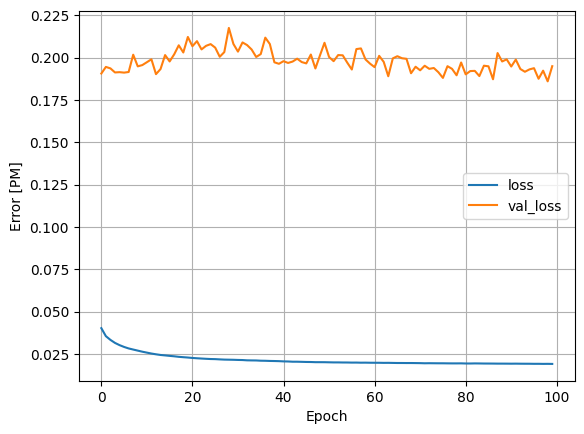

In [143]:
plot_loss(history)

### Model Save

In [67]:
if os.path.isdir("./saved_model") and os.path.isdir("./saved_model_weights") is False:
    os.mkdir("./saved_model")
    os.mkdir("./saved_model_weights")
    
model.save(f'./saved_model/model_0.01')
model.save(f'./saved_model_weights/model_0.01.h5')

INFO:tensorflow:Assets written to: ./saved_model/model_0.01\assets


In [13]:

model.load_weights("saved_model_weights\model_0.01.h5")

In [14]:

X = train_df[train_df['profile_id'] != 17].drop(columns = ['pm','profile_id'])
y = train_df['pm'][train_df['profile_id'] != 17]

X_test = train_df[train_df['profile_id'] == 17].drop(columns = ['pm','profile_id'])
y_test = train_df['pm'][train_df['profile_id'] == 17]

scaler1 = StandardScaler()
scaler2 = StandardScaler()
X = scaler1.fit_transform(X)
y = scaler2.fit_transform(np.asarray(y).reshape(-1, 1))

X_test = scaler1.transform(X_test)
y_test = scaler2.transform(np.asarray(y_test).reshape(-1, 1))

y_pred = model.predict(X_test)

y_pred = scaler2.inverse_transform(y_pred)
y_test = scaler2.inverse_transform(y_test)

print('Actual values:')
print(y_test[500])
print('Predicted values:')
print(y_pred[500])



499/499 [==============================] - 0s 335us/step
Actual values:
[40.103]
Predicted values:
[41.357]
